# Introduction to ehrapy

Welcome to ehrapy! 


ehrapy is a framework for the exploratory and targeted end-to-end analysis of complex electronic health record (EHR) datasets inspired by the biological omics world.
Hereby, data points are not necessarily treated as complete patients, but as patient visits representing snapshots of the underlying system.
The goal of any exploratory analysis not necessarily is to predict or classify a specific state, but to understand the system underlying the data manifold.

ehrapy is not a pure machine learning library or a pure statistics library, but a framework providing simplified access to fundamental algorithms to preprocess, visualize and analyze EHR data.

## Fundamental Principles

One of the main advantages of ehrapy is that EHR datasets can be analyzed from beginning to end with a clear, but flexible, order of operations.

![](images/ehrapy_overview.png)

ehrapy borrows a lot from the single-cell world and the [scverse](https://github.com/scverse/) ecosystem. Notably, ehrapy is using the same data structure (AnnData) and many of the fundamental algorithms (scanpy). Both are briefly introduced in the following subsections.

## AnnData

AnnData is short for Annotated Data and is the primary data structure used within ehrapy. Technically described, it is a Python package for handling annotated data matrices in memory and on disk, positioned between Pandas and xarray. AnnData offers a broad range of computationally efficient features including, among others, sparse data support, lazy operations, and a PyTorch interface. From a users perspective, it is based on the idea of a primary 2D matrix `X` of, for example, dimensions `n_patient_visits x n_features`. The patient visits would then also be the observations (`obs`) and the features would be the variables (`var`). AnnData allows us to annotate this matrix either with respect to the observations or the variables. Furthermore, AnnData allows for the addition of graph like structures (`obsp, varp`) and further structured (`obsm, varm`) and unstructured matrices (`uns`) to be saved within the same object. These can than be readily used for various machine learning algorithms.

Visualized it looks like this:


![](images/anndata_schema.jpg)

Let us create an example AnnData object as it would be used in ehrapy.

In [1]:
import anndata as ad
import pandas as pd
import numpy as np

After importing the required packages, we create an example dataset with a **patient_visit_id** column and some feature columns such as **age**, **b12_level** and **d3_level**. We further add a **service_unit** column that we do not want to include as data for our algorithms, but only as annotations.

In [2]:
data = {
    "patient_visit_id": [0, 1, 2],
    "age": [59, 24, 64],
    "b12_level": [560, 201, 450],
    "d3_level": [25, 19, 50],
    "service_unit": ["NY", "NY", "BO"],
}
df = pd.DataFrame(data)

In [3]:
df

,patient_visit_id,age,b12_level,d3_level,service_unit
0,0,59,560,25,NY
1,1,24,201,19,NY
2,2,64,450,50,BO


Next, we import ehrapy and create an AnnData object using this Pandas DataFrame. Usually, EHR data comes in the form of `csv/tsv` tables that can be directly read into ehrapy using [`ep.io.read_csv()`](https://ehrapy.readthedocs.io/en/latest/usage/io/ehrapy.io.read_csv.html). For the sake of this example we transform an existing Pandas DataFrame into an AnnData object using the `df_to_anndata` function. Note that it has a `index_column` parameter to set the index and a `columns_obs_only` parameter which denotes features which should not be a part of the `X` matrix but of `obs` annotations. This will allow us to e.g. color plots by `service_unit`, but not to use these values for algorithms.

In [ ]:
import ehrapy as ep

In [ ]:
adata = ep.ad.df_to_anndata(
    df, index_column="patient_visit_id", columns_obs_only=["service_unit"]
)

/home/zeth/PycharmProjects/ehrapy/ehrapy/anndata/anndata_ext.py:108: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  X = X.astype(np.number) if all_num else X.astype(object)


In [ ]:
adata

AnnData object with n_obs × n_vars = 3 × 3
    obs: 'service_unit'
    var: 'ehrapy_column_type'
    layers: 'original'

When examining our AnnData object we notice that it has a matrix of size 3 x 3 which correspond to our **age**, **B12** and **D3** measurements.

In [ ]:
adata.obs

,service_unit
patient_visit_id,
0,NY
1,NY
2,BO


Furthermore, our `obs` has the service unit as expected. The AnnData object also has data in the `uns` (unstructured) slot that denotes which columns are numerical columns and which ones are not. This may be required for specific algorithms.

In [ ]:
adata.uns

Finally, the `layers` slot of our object saves all original values before any modifications in `original`. When using ehrapy, the `X` matrix will constantly be modified when applying algorithms to the object (e.g. scaling). This layer is a copy of our original `X` which will allow us to e.g. scale the age, but use the original values when coloring a UMAP plot.

In [ ]:
adata.layers["original"]

array([[ 59., 560.,  25.],
       [ 24., 201.,  19.],
       [ 64., 450.,  50.]])

For more details please examine the [AnnData documentation](https://anndata.readthedocs.io/en/latest/) and the [AnnData paper](https://www.biorxiv.org/content/10.1101/2021.12.16.473007v1).

## scanpy

[scanpy](https://github.com/theislab/scanpy/) is a framework for the analysis of single-cell data and ehrapy heavily builds upon it. While some of the implemented algorithms are single-cell specific (e.g. the **highly_variable_genes** function), many can be applied to any data (e.g. PCA or UMAP). ehrapy may also implement equivalents of single-cell specific functions that are EHR specific (e.g. the **highly_variable_features** function). All useful scanpy functions are wrapped in ehrapy to ensure that they are easily accessible and implemented in a fast and scalable way.

![](images/scanpy.jpg)

Just like scanpy, ehrapy follows the same API patterns of preprocessing (pp), tools (tl) and plots (pl). Hence, the various functions from scanpy like `scanpy.tl.umap` can be used from ehrapy in a similar fashion: `ep.tl.umap`.

The documentation of ehrapy tries to hide as many details from the single-cell world as possible, but you may see the terms cell, gene or expression pop up somewhere. However, the tight integration of AnnData and scanpy into ehrapy also allows for the joint analysis of omics data and EHR data. We will provide a vignette for this in the future.

To learn more about scanpy please read the [scanpy documentation ](https://scanpy.readthedocs.io/en/stable/) and the [scanpy paper ](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0).

## ehrapy

Now that we've covered the basics of AnnData and scanpy and we have an example dataset, we can apply some of ehrapy's tools on it.
We will start by calculating and visualizing a PCA on our data.

In [ ]:
ep.pp.pca(adata)

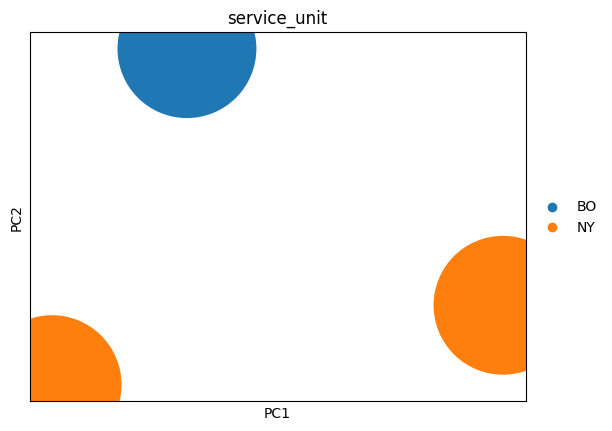

In [ ]:
ep.pl.pca(adata, color="service_unit")

This is of course not a useful analysis since we only have three visits.

## Making your dataset ready for ehrapy

### Data types

ehrapy requires data to be in two dimensional, vectorized format meaning anything that could be stored in a single Pandas DataFrame is suitable.
It does not matter whether the data originally came from a database or several CSV files.

In [ ]:
# This is NOT okay
data = {
    "MixedColumn1": ["Apple", 10, "Banana", 20],
    "MixedColumn2": [15, "Cherry", 5, "Date"],
}
df = pd.DataFrame(data)
df

,MixedColumn1,MixedColumn2
0,Apple,15
1,10,Cherry
2,Banana,5
3,20,Date


In [ ]:
# This is okay
data = {
    "Column1": ["Apple", "Banana", "Cherry", "Date"],
    "Column2": [10, 20, 15, 5],
    "Column3": [True, False, True, False],
    "Column4": [
        pd.Timestamp("2023-08-01"),
        pd.Timestamp("2023-08-15"),
        pd.Timestamp("2023-08-10"),
        pd.Timestamp("2023-08-05"),
    ],
    "Column5": pd.Categorical(["dead", "alive", "dead", "dead"]),
}

df = pd.DataFrame(data)
df

,Column1,Column2,Column3,Column4,Column5
0,Apple,10,True,2023-08-01,dead
1,Banana,20,False,2023-08-15,alive
2,Cherry,15,True,2023-08-10,dead
3,Date,5,False,2023-08-05,dead


In [ ]:
adata = ep.ad.df_to_anndata(df)
adata

AnnData object with n_obs × n_vars = 4 × 5
    var: 'ehrapy_column_type'
    layers: 'original'

### Feature groups

For many analyses with ehrapy it is useful to group together features that belong to the same data modality.
Examples are high level groups such as demography values, lab or vital sign measurements.
This allows for simpler groupbys or the creation of subsets:

In [ ]:
data = {
    "gender": pd.Categorical(["male", "female", "female", "male"]),
    "age": [10, 20, 15, 5],
    "b12": [300, 600, 800, 500],
    "d3": [25, 30, 28, 21],
}
df = pd.DataFrame(data)
df

,gender,age,b12,d3
0,male,10,300,25
1,female,20,600,30
2,female,15,800,28
3,male,5,500,21


In [ ]:
adata = ep.ad.df_to_anndata(df)
adata.var

,ehrapy_column_type
gender,non_numeric
age,numeric
b12,numeric
d3,numeric


In [ ]:
demographics_features = ["age", "gender"]
lab_measurements_features = ["b12", "d3"]

# Assign the measurement groups to features in .var
measurement_group = []

for feature in adata.var_names:
    if feature in demographics_features:
        measurement_group.append("demographics")
    elif feature in lab_measurements_features:
        measurement_group.append("lab_measurements")

adata.var["measurement_group"] = measurement_group

In [ ]:
adata_demographics = adata[:, adata.var["measurement_group"] == "demographics"]
adata_demographics

View of AnnData object with n_obs × n_vars = 4 × 2
    var: 'ehrapy_column_type', 'measurement_group'
    layers: 'original'

### Units

EHR measurements are recorded in specific units that are ideally stored with the measurements:

In [ ]:
data = {
    "gender [categorical]": pd.Categorical(["male", "female", "female", "male"]),
    "age [years]": [10, 20, 15, 5],
    "b12 [pg/mL]": [300, 600, 800, 500],
    "d3 [ng/mL]": [25, 30, 28, 21],
}
df = pd.DataFrame(data)
df

,gender [categorical],age [years],b12 [pg/mL],d3 [ng/mL]
0,male,10,300,25
1,female,20,600,30
2,female,15,800,28
3,male,5,500,21


In [ ]:
adata = ep.ad.df_to_anndata(df)

# Extract feature names and units from var_names and store separately
feature_names = [var_name.split("[")[0].strip() for var_name in adata.var_names]
unit_annotations = [
    var_name.split("[")[-1][:-1] if "[" in var_name else ""
    for var_name in adata.var_names
]

# Update .var with feature names and units separately
adata.var_names = feature_names
adata.var["units"] = unit_annotations

In [ ]:
adata.var

,ehrapy_column_type,units
gender,non_numeric,categorical
age,numeric,years
b12,numeric,pg/mL
d3,numeric,ng/mL


In [ ]:
d3_unit = adata.var["units"]["d3"]
print(f"Unit of 'd3': {d3_unit}")

Unit of 'd3': ng/mL


## Conclusion

To get started check out the [MIMIC-II introduction tutorial](https://ehrapy.readthedocs.io/en/latest/tutorials/mimic_2_introduction.html) where you will learn to apply ehrapy to a real dataset to investigate the effect of intdwelling artherical catheters on patient survival over multiple notebooks.

Please also consider consulting the [ehrapy API](https://ehrapy.readthedocs.io/en/latest/usage/usage.html) documentation.